In [1]:
## EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import shap

## feature engineering libraries
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


## model preparation libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

## model evaluation libraries
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold

## model hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import joblib
%matplotlib inline

### Import Data And Preprocessing...
According to data dictionary, we have 3 unknown fields, fruitset, fruitmass, seeds having high correlation values with the target varialble, the yield value.

In [2]:
berry_data = pd.read_csv('WildBlueberryPollinationSimulationData.csv')
berry_data.head(10)

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543
5,5,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.309669,0.366284,27.345454,2825.003738
6,6,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.284443,0.352186,26.101179,2625.269164
7,7,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.246568,0.342826,25.042361,2379.905214
8,8,37.5,0.75,0.25,0.25,0.25,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.427977,0.414711,32.334153,4234.868585
9,9,37.5,0.75,0.25,0.25,0.25,77.4,46.8,64.7,55.8,27.0,45.8,1.0,0.10,0.464366,0.436346,34.849953,5356.871861


# EDA

In [3]:
berry_data.shape

(777, 18)

In [4]:
berry_data.isna().sum()

Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

In [5]:
#Descriptive statistics..
def describe(my_df):
    cols = []
    for i in my_df.columns:
        if my_df[i].dtype != 'object':
            cols.append(i)
            
    result = pd.DataFrame(columns = cols, index=['Datatype', 'Count', 'min', 'Q1', 'Q2', 'mean', 'Q3', 'max', 'Std',
                                                 'Skewness', 'Kurtosis', 'Range', 'IQR', 'Skewness comment', 'Outlier comment',
                                                'Kurtosis comment'])
    
    #Building custom summary
    for i in result.columns:
        result.loc['Datatype', i] = my_df[i].dtype
        result.loc['Count', i] = my_df[i].count()
        result.loc['min',i] = my_df[i].min()
        result.loc['Q1',i] = my_df[i].quantile(0.25)
        result.loc['Q2',i] =my_df[i].quantile(0.5)
        result.loc['mean',i] =round(my_df[i].mean(),2)
        result.loc['Q3',i] =my_df[i].quantile(0.75)
        result.loc['max',i] =my_df[i].max()
        result.loc['Std',i] =round(my_df[i].std(),2)
        result.loc['Skewness',i] =round(my_df[i].skew(),2)
        result.loc['Kurtosis',i] =round(my_df[i].kurt(),2)
        result.loc['Range',i] = my_df[i].max() - my_df[i].min()
        result.loc['IQR',i] = my_df[i].quantile(0.75) - my_df[i].quantile(0.25)
        
        
        #Adding comments for skewness
        if result.loc['Skewness', i] <= -1:
            sk_label = 'Highly negatively skewed'
        elif -1  < result.loc['Skewness', i] <= -0.5:
            sk_label = 'Moderatively negatively Skewed'
        elif -0.5  < result.loc['Skewness', i] < 0:
            sk_label = 'Approximately Normal distribution(-ve)'
        elif 0  <= result.loc['Skewness', i] < 0.5:
            sk_label = 'Approximately Normal distribution(+ve)'
        elif 0.5  <= result.loc['Skewness', i] < 1:
            sk_label = 'Moderatively positively Skewed'
        elif result.loc['Skewness', i] >= 1:
            sk_label = 'Highly positively Skewed'
        else:
            sk_label = 'Error'
            
        result.loc['Skewness comment', i] = sk_label
            
            
            
         #Adding comments for Kurtosis
        if result.loc['Kurtosis', i] <= -1:
            kt_label = 'Highly platykurtic curve'
        elif -1  < result.loc['Kurtosis', i] <= -0.5:
            kt_label = 'Moderatively platykurtic curve'
        elif -0.5  < result.loc['Kurtosis', i] < 0.5:
            kt_label = 'Mesokurtic curve'
        elif 0.5  <= result.loc['Kurtosis', i] < 1:
            kt_label = 'Moderatively laptokurtic curve'
        elif result.loc['Kurtosis', i] >= 1:
            kt_label = 'Highly laptokurtic curve'
        else:
            kt_label = 'Error'
            
        result.loc['Kurtosis comment', i] = kt_label
        
        
        #Adding comments for Outliers
        upper_limit = result.loc['Q3',i] + (1.5 * result.loc['IQR', i])
        lower_limit = result.loc['Q1', i]- (1.5 * result.loc['IQR', i])
        if len([x for x in my_df[i] if x < lower_limit or x > upper_limit]) > 0:
            outlier_label = 'Has outliers'
        else:
            outlier_label = 'No outliers'
            
        result.loc['Outlier comment', i] = outlier_label
    display(result)

In [6]:
describe(berry_data)

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
Datatype,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Count,777,777,777,777,777,777,777,777,777,777,777,777,777,777,777,777,777,777
min,0,10.0,0.0,0.0,0.0,0.0,69.7,39.0,58.2,50.2,24.3,41.2,1.0,0.06,0.192732,0.311921,22.079199,1637.704022
Q1,194.0,12.5,0.25,0.25,0.38,0.5,77.4,46.8,64.7,55.8,27.0,45.8,3.77,0.1,0.454725,0.416281,33.116091,5124.854901
Q2,388.0,12.5,0.25,0.25,0.5,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.508297,0.445587,36.166044,6107.382466
mean,388.0,18.77,0.42,0.28,0.47,0.56,82.28,49.7,68.72,59.31,28.69,48.61,18.31,0.32,0.5,0.45,36.12,6012.85
Q3,582.0,25.0,0.5,0.38,0.63,0.75,89.0,52.0,71.9,66.0,30.0,50.8,24.0,0.39,0.561297,0.476149,39.239668,7022.189731
max,776,40.0,18.43,0.585,0.75,0.75,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.652144,0.53566,46.585105,8969.401842
Std,224.44,7.0,0.98,0.07,0.16,0.17,9.19,5.6,7.68,6.65,3.21,5.42,12.12,0.17,0.08,0.04,4.38,1356.96
Skewness,0.0,0.58,16.76,0.15,0.19,-0.92,-0.01,-0.02,-0.02,-0.02,-0.01,-0.01,-0.21,0.07,-0.52,-0.1,-0.06,-0.32


We have no null values, and overall dtype of the dataset is float

### Univariate Analysis

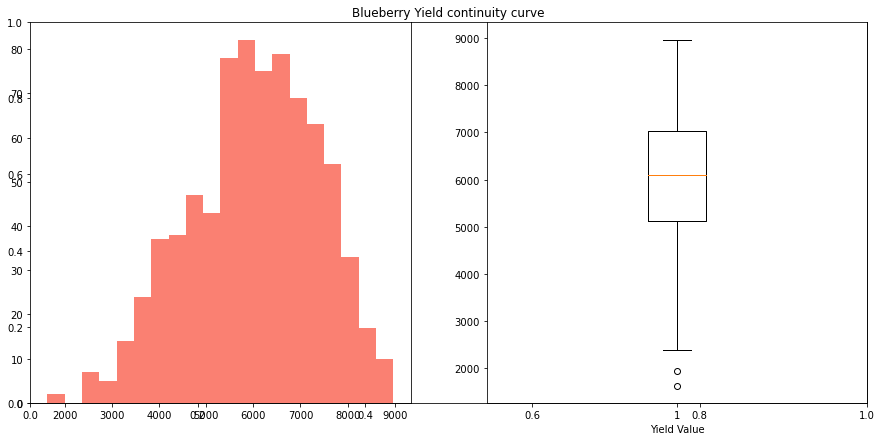

In [7]:
#Approx. normal distribution bell shaped curve...
figs = plt.figure(figsize=(15,7))
plt.title("Blueberry Yield continuity curve")
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = berry_data["yield"]
plt.xlabel("Yield Value")
ax1.hist(x, bins=20, color="salmon")
ax2.boxplot(x);

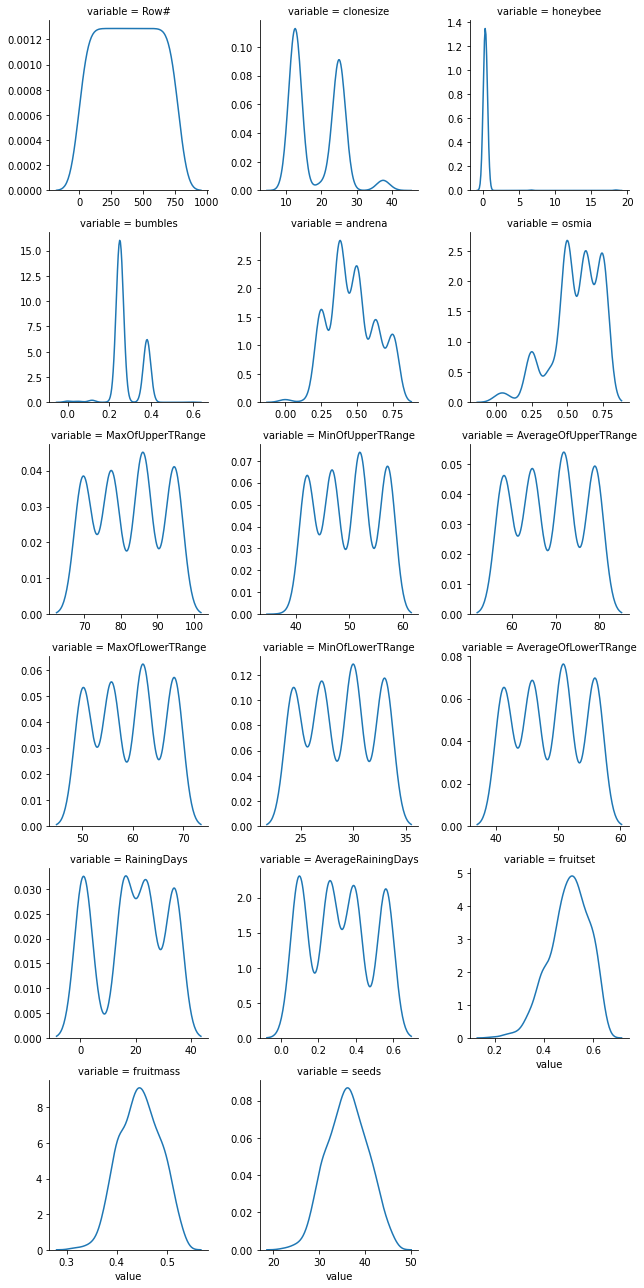

In [8]:
unpivot = pd.melt(berry_data, berry_data.describe().columns[-1], berry_data.describe().columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


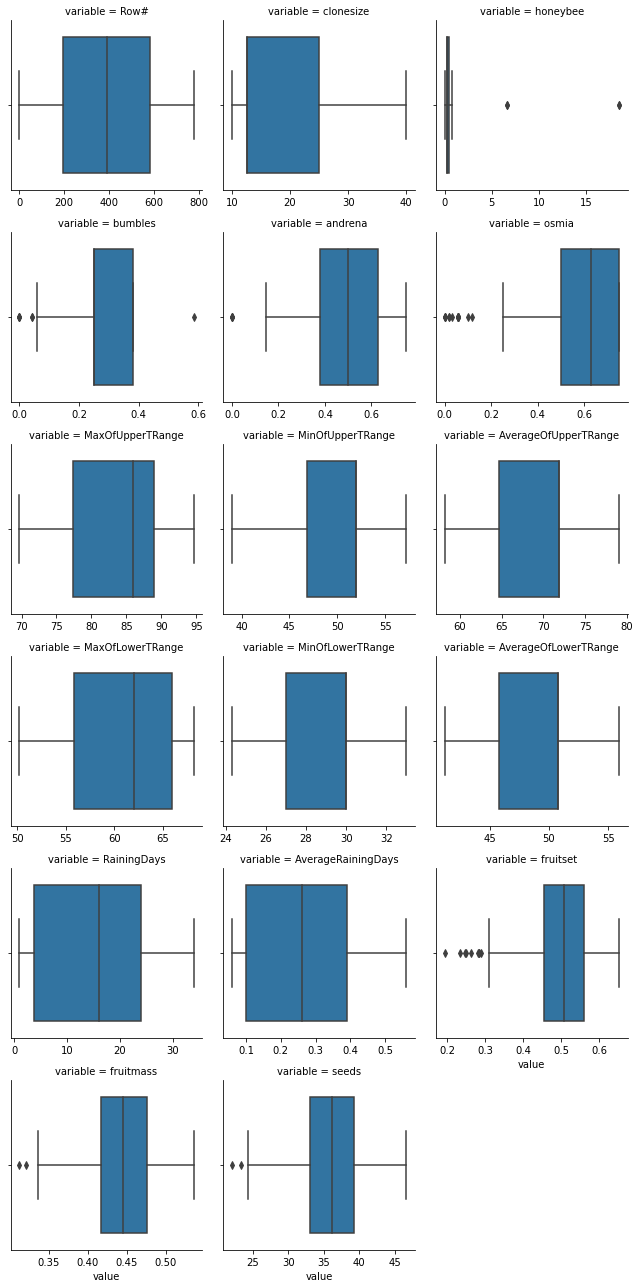

In [9]:
unpivot = pd.melt(berry_data, berry_data.describe().columns[-1], berry_data.describe().columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")

plt.show()

### Multivariate analysis using regression

###### Analysis:
- Seeds, fruitmass, fruitset, osmia, bumbles have positive correlation with target (yield).

- donesize, maxofupperrange, minofupperrange, avgofupperrange, maxoflowerTrange, minoflowerTrange, avgoflowerTrange, rainydays and avgrainydays have negative correlation with target (yield).


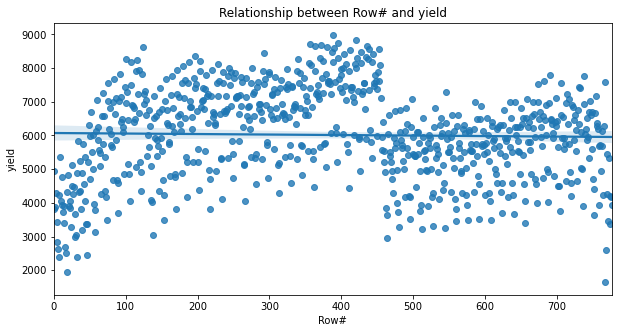

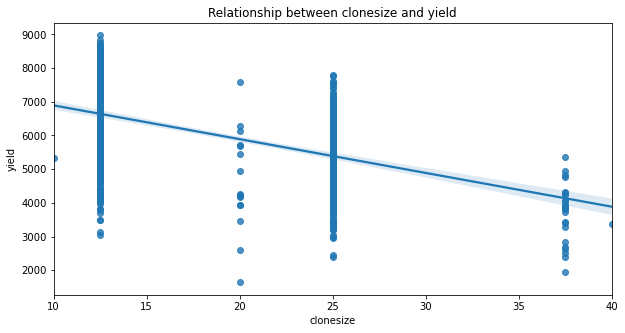

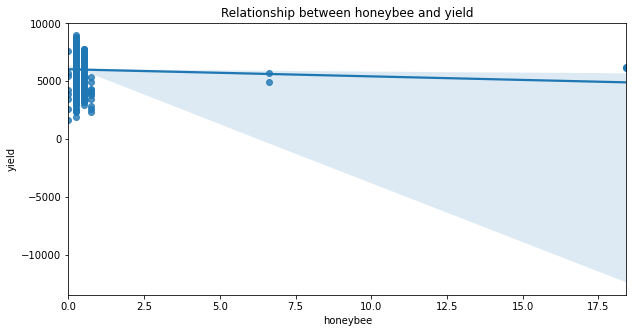

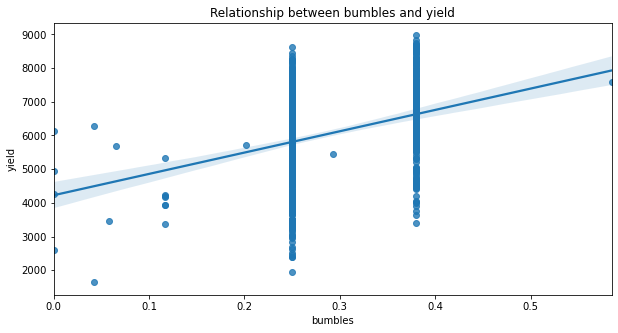

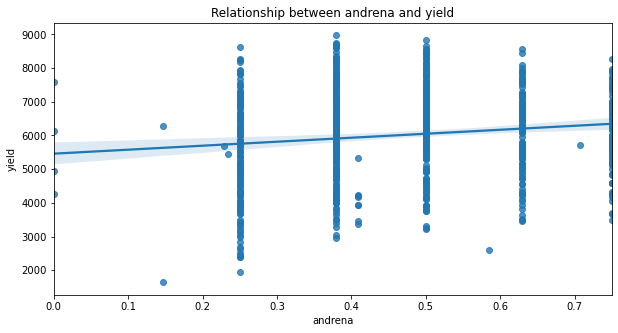

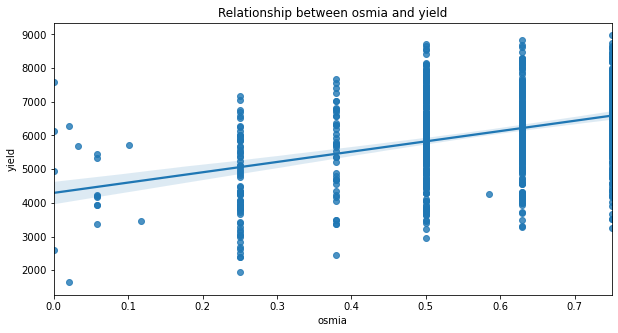

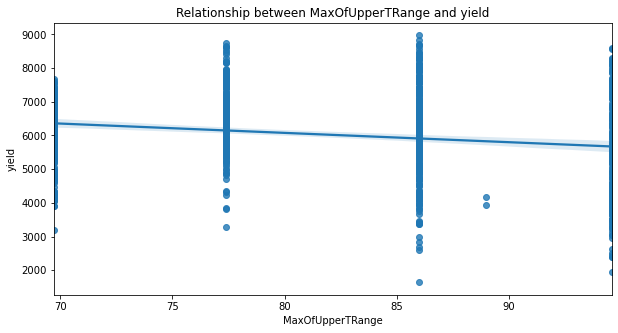

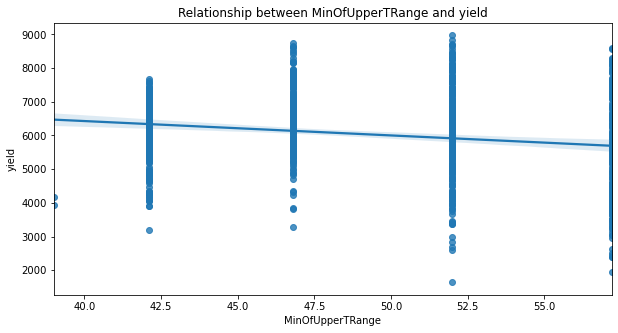

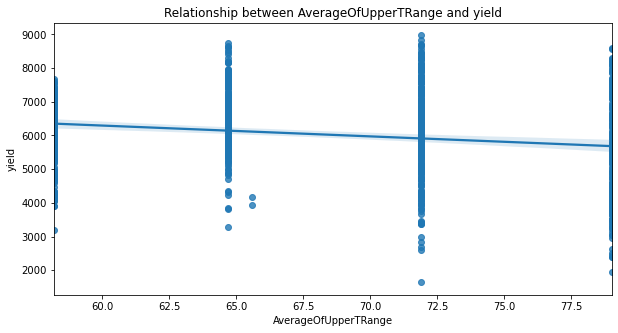

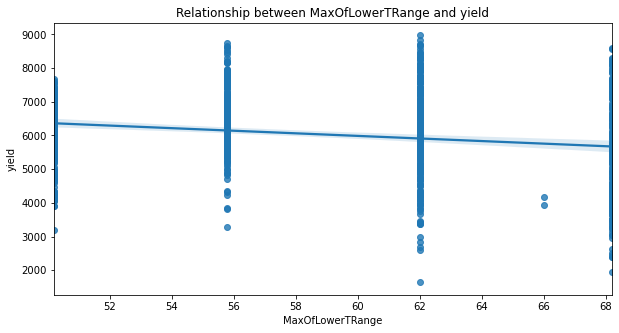

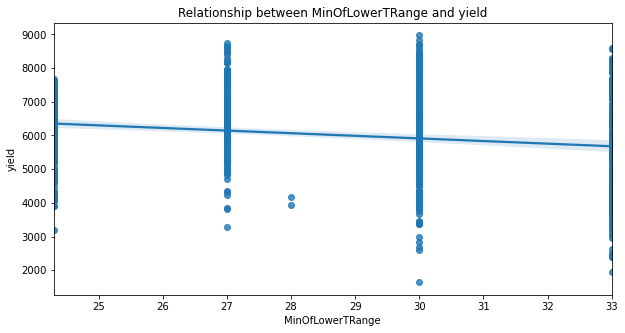

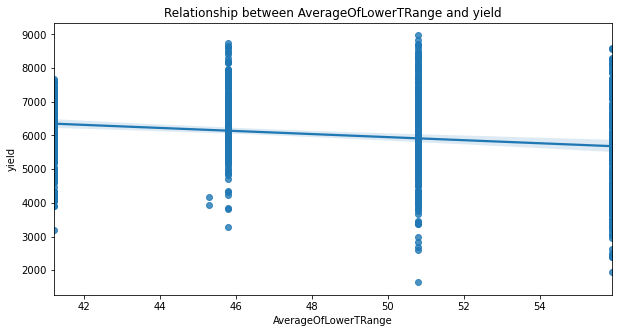

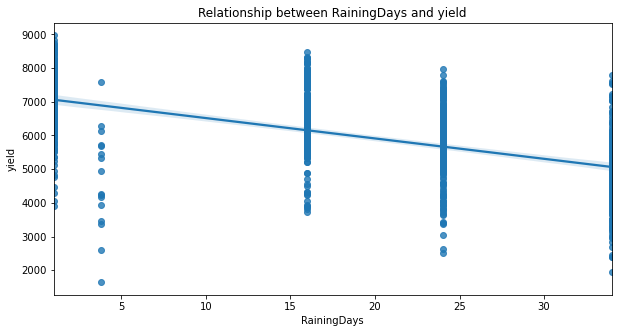

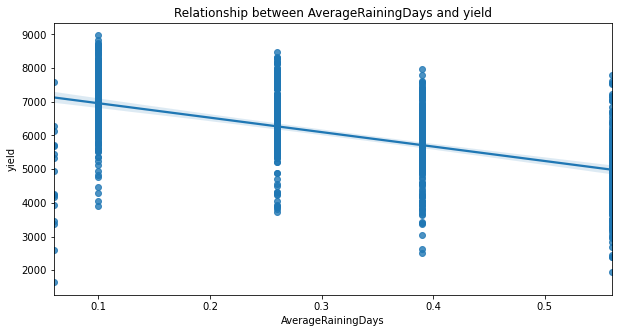

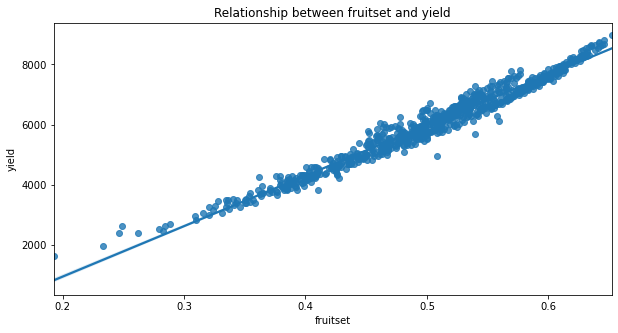

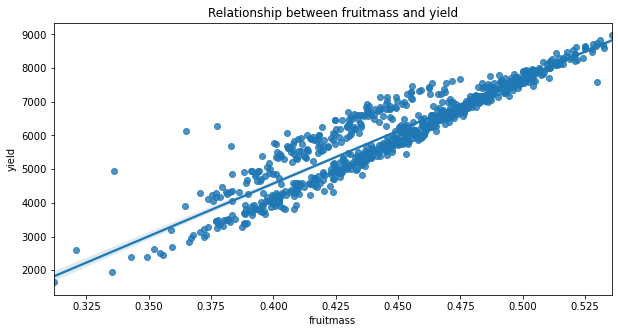

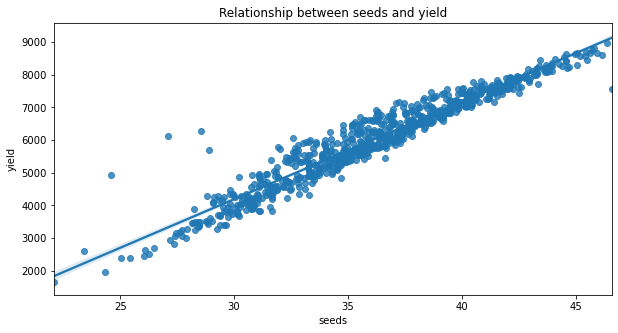

In [10]:
for col in berry_data.columns:
    if col != 'yield':
        fig, ax1 = plt.subplots(figsize= (10, 5))
        sns.regplot(x= berry_data[col], y=berry_data['yield'], ax=ax1).set_title(f'Relationship between {col} and yield')

<!-- MinOfUpperTRange, MinOfLowerTRange, MaxOfLowerTRange, MaxOfUpperTRange having perfect multicollinearity-->

<AxesSubplot:>

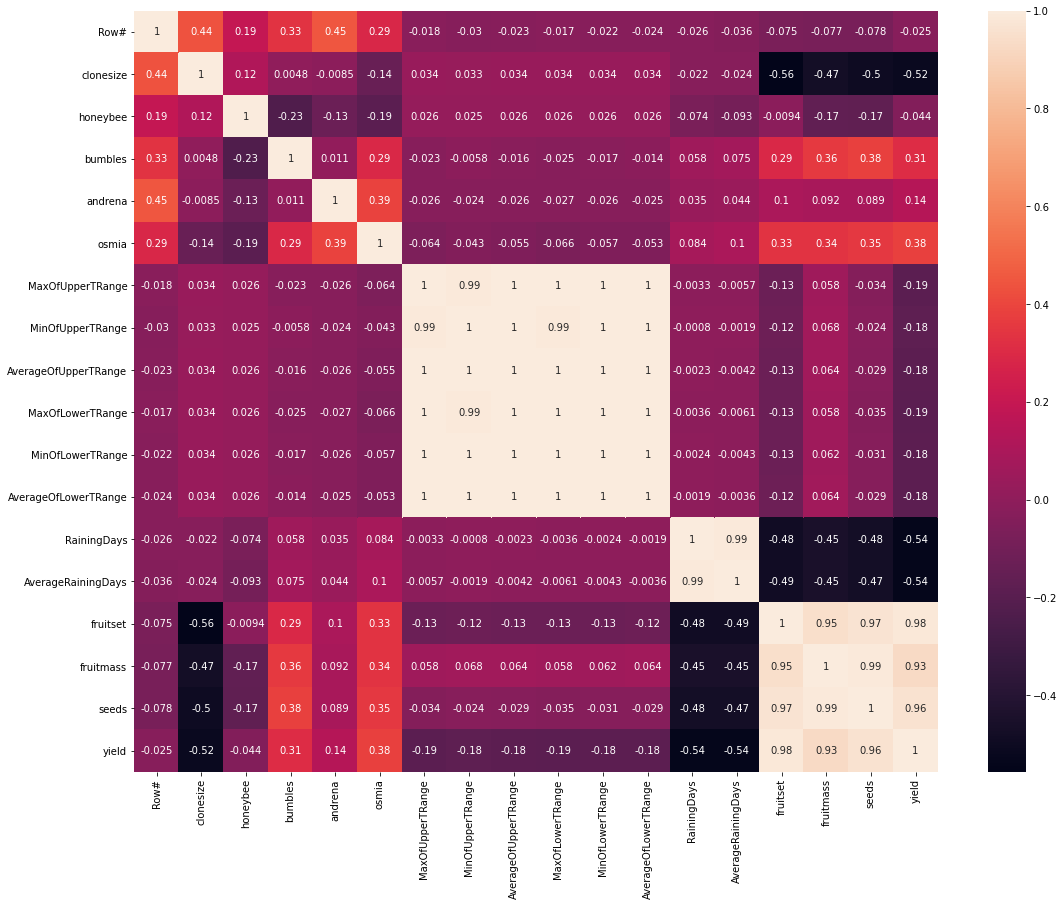

In [11]:
#Multicollinearity check using heatmap
corr = berry_data.corr()
f, ax = plt.subplots(figsize= (18,14))
sns.heatmap(corr, annot=True)

In [12]:
# MinOfUpperTRange, MinOfLowerTRange, MaxOfLowerTRange, MaxOfUpperTRange, AverageOfUpperTRange, AverageOfLowerTRange having perfect multicollinearity.
def VIF(features):
    VIF = pd.DataFrame()
    VIF['vif_factor'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    VIF['features'] = features.columns
    return VIF.sort_values('vif_factor', ascending= False)

In [13]:
VIF(berry_data.drop('yield', axis=1))

divide by zero encountered in double_scalars


,vif_factor,features
7,inf,MinOfUpperTRange
10,inf,MinOfLowerTRange
9,inf,MaxOfLowerTRange
6,inf,MaxOfUpperTRange
8,9.818622e+07,AverageOfUpperTRange
11,4.932612e+07,AverageOfLowerTRange
15,7.690683e+02,fruitmass
16,5.668357e+02,seeds
14,8.129928e+01,fruitset
13,7.817718e+01,AverageRainingDays


## Preprocessing
columns to drop: 'Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays', 'honeybee'

In [14]:
bbry_data_process = berry_data.drop(columns=['Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays', 'honeybee'])
bbry_data_process

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26,0.410652,0.408159,31.678898,3813.165795
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10,0.444254,0.425458,33.449385,4947.605663
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26,0.383787,0.399172,30.546306,3866.798965
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10,0.407564,0.408789,31.562586,4303.943030
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39,0.354413,0.382703,28.873714,3436.493543
...,...,...,...,...,...,...,...,...,...,...,...
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06,0.486815,0.428012,33.447471,5333.873335
773,40.0,0.117,0.409,0.058,71.9,50.8,0.06,0.342841,0.377915,28.462005,3373.436842
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39,0.404617,0.401670,30.748240,4203.027624
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06,0.401538,0.399935,30.582161,4166.299735


In [15]:
part1 = bbry_data_process.drop(columns=['yield'])
part2 = bbry_data_process[['yield']]

In [16]:
Q1 = part1.quantile(0.25)
Q3 = part1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

clonesize               12.500000
bumbles                  0.130000
andrena                  0.250000
osmia                    0.250000
AverageOfUpperTRange     7.200000
AverageOfLowerTRange     5.000000
AverageRainingDays       0.290000
fruitset                 0.106571
fruitmass                0.059869
seeds                    6.123577
dtype: float64


In [17]:
bbry_data_iqr = bbry_data_process[~((bbry_data_process < (Q1 - 1.5 * IQR)) | (bbry_data_process > (Q3 + 1.5 * IQR))).any(axis=1)]
bbry_data_iqr.shape

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


(752, 11)

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


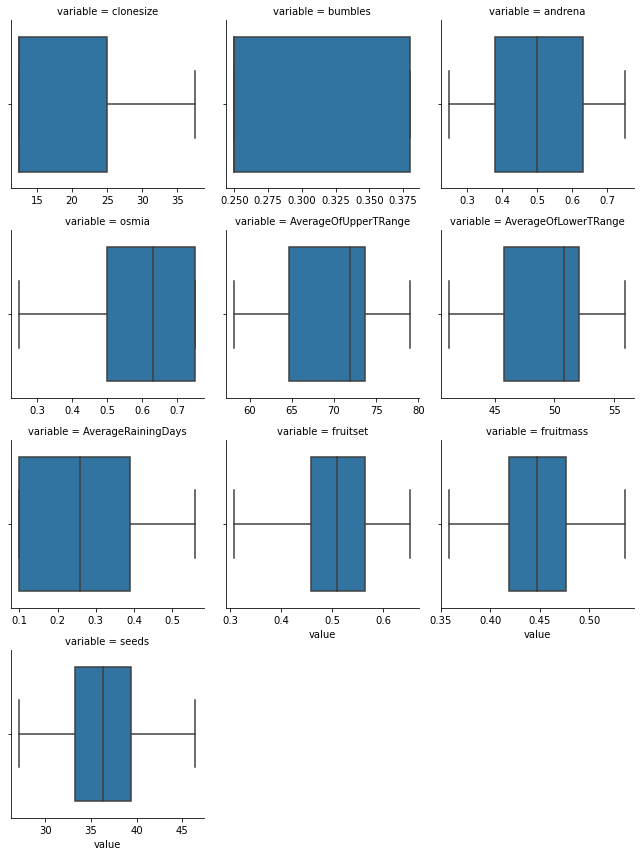

In [18]:
unpivot = pd.melt(bbry_data_iqr, bbry_data_iqr.describe().columns[-1], bbry_data_iqr.describe().columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")

plt.show()

In [19]:
# 

In [20]:
z = np.abs(stats.zscore(bbry_data_process))
print(z)

[[2.67812564 0.4885117  1.35954903 ... 0.93841323 1.01564827 1.62208748]
 [2.67812564 0.4885117  1.35954903 ... 0.50923815 0.61097218 0.7855304 ]
 [2.67812564 0.4885117  1.35954903 ... 1.16136881 1.27452236 1.58253738]
 ...
 [0.17618037 2.4945233  0.37165479 ... 1.0994045  1.22836665 1.33459611]
 [0.17618037 2.4945233  0.37165479 ... 1.14243699 1.26632705 1.36167994]
 [0.17618037 2.4945233  0.37165479 ... 1.33180188 1.45822756 1.52624822]]


In [21]:
bbry_data_zscore = bbry_data_process[(z < 3).all(axis=1)]
bbry_data_zscore.shape

(764, 11)

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


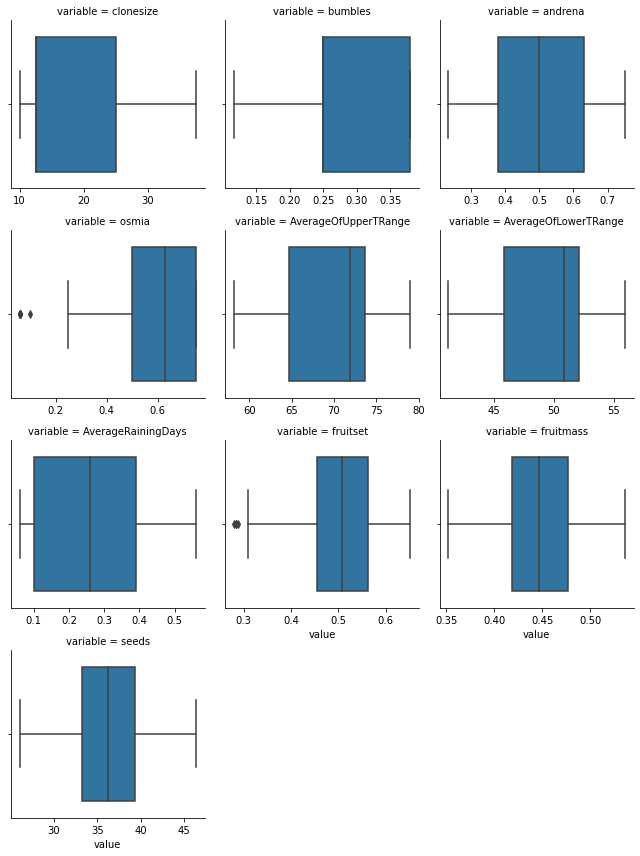

In [22]:
unpivot = pd.melt(bbry_data_zscore, bbry_data_zscore.columns[-1], bbry_data_zscore.columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")


plt.show()



In [23]:
bbry_data_process = bbry_data_zscore
bbry_data_process

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26,0.410652,0.408159,31.678898,3813.165795
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10,0.444254,0.425458,33.449385,4947.605663
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26,0.383787,0.399172,30.546306,3866.798965
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10,0.407564,0.408789,31.562586,4303.943030
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39,0.354413,0.382703,28.873714,3436.493543
...,...,...,...,...,...,...,...,...,...,...,...
770,20.0,0.293,0.234,0.058,71.9,50.8,0.06,0.497503,0.453339,36.633376,5449.421199
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06,0.486815,0.428012,33.447471,5333.873335
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39,0.404617,0.401670,30.748240,4203.027624
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06,0.401538,0.399935,30.582161,4166.299735


### Feature Selection
As a part of which, we will perform feature selection.

We have created 2 splits on Dataset, and each will be analysed on the importance of either Mutual Information gain or Correlation Regression values

In [24]:
def select_features_corr_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(X_train, y_train)
    X_train_fs = fs_corr.transform(X_train)
    X_test_fs = fs_corr.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_corr

def select_features_infogain_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_info = SelectKBest(score_func=mutual_info_regression, k='all')
    else:
        fs_info = SelectKBest(score_func=mutual_info_regression, k=x)
    fs_info.fit(X_train, y_train)
    X_train_fs = fs_info.transform(X_train)
    X_test_fs = fs_info.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_info

In [25]:
X = bbry_data_process.drop(["yield"], axis=1)
y = bbry_data_process['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

X_train_fs_corr, X_test_fs_corr, fs_corr = select_features_corr_based(X_train, y_train, X_test)
X_train_fs_info, X_test_fs_info, fs_info = select_features_infogain_based(X_train, y_train, X_test)

I would have to perform many folds of tuning on the decided dataset, hence I would have to choose either one option of the below

info-gain vs correlation
- The KSelection score plot describes a good behavior of the Information Gain Values. Hence, all the dataset will be based on the same

Feature 0: 175.463722
Feature 1: 35.414625
Feature 2: 8.092982
Feature 3: 95.866044
Feature 4: 23.685723
Feature 5: 23.512387
Feature 6: 265.725911
Feature 7: 18027.130769
Feature 8: 3685.065541
Feature 9: 8199.278441


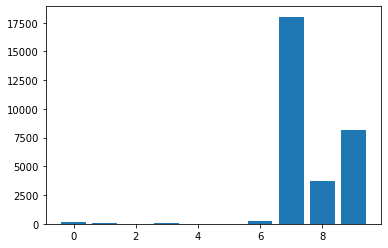

Feature 0: 0.171179
Feature 1: 0.076644
Feature 2: 0.045670
Feature 3: 0.111131
Feature 4: 0.127531
Feature 5: 0.127380
Feature 6: 0.218028
Feature 7: 2.052741
Feature 8: 1.629359
Feature 9: 1.691315


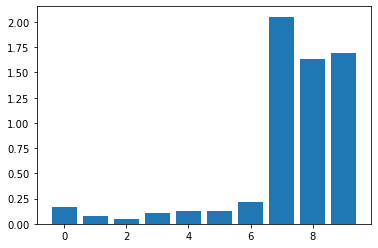

In [26]:
def fs_score_plot(fs_func):
    
    for i in range(len(fs_func.scores_)):
        print('Feature %d: %f' % (i, fs_func.scores_[i]))
    # plot the scores
    plt.bar([i for i in range(len(fs_func.scores_))], fs_func.scores_)
    plt.show()
    
fs_score_plot(fs_corr)
fs_score_plot(fs_info)

## Modelling
We will now train the model on top 9 features, using both the splits of dataset and check the metrics of the same on 4 Models

- Linear Regression
- Random Forest
- Decision Tree
- XGBoost

In [27]:
def train_and_test_split(data, tcol, Test_size=0.3, Random_state = 42):
    x = data.drop(tcol, axis= 1)
    y = data[tcol]
    return train_test_split(x, y, test_size= Test_size, random_state=Random_state)

In [28]:
def build_model(model_name, estimator, data, tcol):
    xtrain, xtest, ytrain, ytest = train_and_test_split(data, tcol)
    estimator.fit(xtrain, ytrain)
    ypred = estimator.predict(xtest)
    rmse = np.sqrt(mean_squared_error(ytest, ypred))
    accuracy = r2_score(ytest, ypred)
    return [model_name, rmse, accuracy]

In [29]:
build_model(model_name= 'Linear Reg', estimator= LinearRegression(), data=bbry_data_process, tcol='yield')

['Linear Reg', 125.13720372238484, 0.9900926514957253]

In [30]:
def multiple_models(data, tcol):
    colnames = ['model_name', 'rmse', 'r2_score']
    result = pd.DataFrame(columns= colnames)
    result.loc[len(result)] = build_model('Linear regression', LinearRegression(), data, tcol)
    result.loc[len(result)] = build_model('RandomForestRegressor', RandomForestRegressor(), data, tcol)
    result.loc[len(result)] = build_model('XGBRegressor', XGBRegressor(), data, tcol)
    result.loc[len(result)] = build_model('DecisionTreeRegressor', DecisionTreeRegressor(), data, tcol)
    
    return result.sort_values('r2_score', ascending= False)

In [31]:
multiple_models(data= bbry_data_process, tcol='yield')

,model_name,rmse,r2_score
0,Linear regression,125.137204,0.990093
2,XGBRegressor,145.006228,0.986697
1,RandomForestRegressor,160.270945,0.983748
3,DecisionTreeRegressor,240.466785,0.963416


### Using Cross validation

In [32]:
def K_fold_CV(x, y, fold=5):
    score_lr = cross_val_score(LinearRegression(), x, y, cv= fold)
    score_dt = cross_val_score(DecisionTreeRegressor(), x, y, cv= fold)
    score_rm = cross_val_score(RandomForestRegressor(), x, y, cv= fold)
    score_xgb = cross_val_score(XGBRegressor(), x, y, cv= fold)
    
    model_names = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor','XGBRegressor']
    
    scores = [score_lr, score_dt, score_rm, score_xgb]
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_names = model_names[i]
        temp = [m_names, score_mean, score_std]
        result.append(temp)
    
    K_fold_df = pd.DataFrame(result, columns= ['model_names', 'score_mean', 'score_std'])
    return K_fold_df.sort_values('score_mean', ascending= False)

In [33]:
#Using cv also Linear reg is performing better
K_fold_CV(x = bbry_data_process.drop('yield', axis=1), y=bbry_data_process['yield'])

,model_names,score_mean,score_std
0,LinearRegression,0.985167,0.006480
3,XGBRegressor,0.970812,0.009400
2,RandomForestRegressor,0.966366,0.012194
1,DecisionTreeRegressor,0.942318,0.023823


### Hyperparameter tuning

In [34]:
def tuning(x,y, fold= 10):
    #parameter grid for all the models
    param_dt = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_features': ['auto','sqrt','log2',2,3,4,5,6,7,8]}
    param_rf = {'n_estimators': [100, 200, 300], 'max_depth': [3,5,7,10]}
    param_xgb = {'eta': [0.01, 0.1, 0.3], 'max_depth':[3,5,7,10], 'subsample': [0.5, 0.7, 1]}
    #param_svr = {}
                
    
    
# hyperparameter tuning (passing hyperparameters in gridsearch)

    tuned_dt = GridSearchCV(DecisionTreeRegressor(), param_dt, cv= fold)
    tuned_rf = GridSearchCV(RandomForestRegressor(), param_rf, cv= fold)
    tuned_xgb = GridSearchCV(XGBRegressor(), param_xgb, cv= fold)
    
    
#Fitting x and y
    tuned_dt.fit(x, y)
    tuned_rf.fit(x, y)
    tuned_xgb.fit(x, y)
    
    tune = [tuned_dt, tuned_rf, tuned_xgb]
    models = ['Decision_Tree', 'Random_forest','XGBoost']
    for i in range(len(tune)):
        print('models: ', models[i])
        print('best_params: ',tune[i].best_params_)

In [35]:
tuning(bbry_data_process.drop('yield', axis=1), y= bbry_data_process['yield'])

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

models:  Decision_Tree
best_params:  {'criterion': 'poisson', 'max_features': 6}
models:  Random_forest
best_params:  {'max_depth': 10, 'n_estimators': 300}
models:  XGBoost
best_params:  {'eta': 0.1, 'max_depth': 7, 'subsample': 0.7}


In [36]:
def CV_post_hyp(x, y, fold=10):
    score_dt = cross_val_score(DecisionTreeRegressor(criterion='friedman_mse', max_features=8), x, y, cv= fold)
    score_rm = cross_val_score(RandomForestRegressor(n_estimators = 200, max_depth=10), x, y, cv= fold)
    score_xgb = cross_val_score(XGBRegressor(eta = 0.1, max_depth=7, subsample=0.7), x, y, cv= fold)
    
    model_names = ['DecisionTreeRegressor', 'RandomForestRegressor','XGBRegressor']
    
    scores = [score_dt, score_rm, score_xgb]
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_names = model_names[i]
        temp = [m_names, score_std, score_mean]
        result.append(temp)
    
    K_fold_df = pd.DataFrame(result, columns= ['model_names', 'score_mean', 'score_std'])
    return K_fold_df.sort_values('score_mean', ascending= False)

In [37]:
CV_post_hyp(x= bbry_data_process.drop('yield', axis=1), y=bbry_data_process['yield'])

,model_names,score_mean,score_std
0,DecisionTreeRegressor,0.025264,0.954207
1,RandomForestRegressor,0.011407,0.974921
2,XGBRegressor,0.008168,0.982705


In [43]:
dt_tuned = DecisionTreeRegressor(criterion='friedman_mse', max_features=8)

dt_tuned.fit(X_train, y_train)
y_pred_tuned = dt_tuned.predict(X_test)

### Explainable AI

In [39]:
shap.initjs()

In [40]:
X_sample = X_train.sample(100)
X_sample

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,fruitset,fruitmass,seeds
354,12.5,0.25,0.75,0.75,58.2,41.2,0.56,0.480386,0.413904,33.331194
112,12.5,0.25,0.25,0.63,64.7,45.8,0.56,0.548725,0.470373,38.378558
132,12.5,0.25,0.38,0.25,71.9,50.8,0.10,0.561190,0.472980,38.639843
341,12.5,0.25,0.75,0.75,79.0,55.9,0.26,0.601161,0.495799,41.363181
128,12.5,0.25,0.25,0.75,64.7,45.8,0.56,0.574989,0.485100,40.171431
...,...,...,...,...,...,...,...,...,...,...
618,25.0,0.25,0.75,0.63,71.9,50.8,0.10,0.514253,0.453028,36.406982
472,25.0,0.25,0.38,0.50,58.2,41.2,0.56,0.375384,0.370481,28.807868
169,12.5,0.25,0.38,0.50,79.0,55.9,0.39,0.436871,0.415161,32.265346
115,12.5,0.25,0.25,0.75,71.9,50.8,0.26,0.611726,0.506024,42.686614


In [44]:
shap_values = shap.TreeExplainer(dt_tuned).shap_values(X_sample)

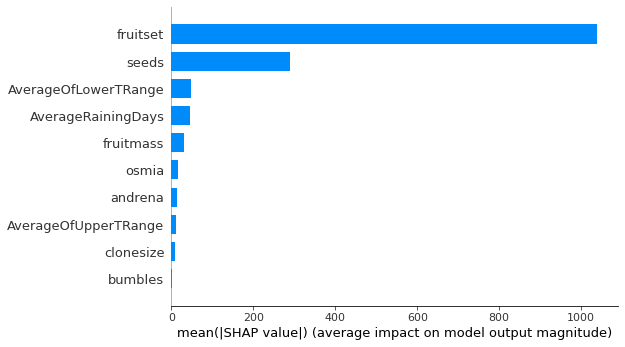

In [45]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

5882.965617


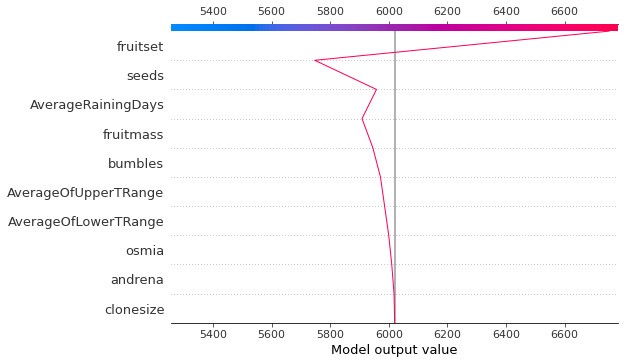

In [54]:
print(y_pred_tuned[10])
shap.decision_plot(shap.TreeExplainer(dt_tuned).expected_value[0], 
                   shap_values[2][:10], 
                   feature_names=X_sample.columns.tolist())